<a href="https://colab.research.google.com/github/MarioAvolio/FoodX-251-Classification-ConvNext-vs-SwinTransformer/blob/main/FoodX_251_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
from google.colab import drive
import pandas as pd
import numpy as np
import cv2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

!pip install torch_summary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:


NUM_CLASSES=251

G_DRIVE='/content/gdrive/'
PROJ_PATH= G_DRIVE+"MyDrive/Visual-Proj/"

# ----------------- tar
TRAIN_PATH = PROJ_PATH + "train.tar"
VAL_PATH = PROJ_PATH + "val.tar"
VAL_DEGRADED_PATH = PROJ_PATH + "val_degraded.zip"
NOISE_TRAINING_DATA_PATH = PROJ_PATH + "noise.zip"
ANNOTATION_PATH = PROJ_PATH + "annot.tar"


# ---------------- local data extracted
TRAIN_PATH_LOCAL="/content/train_set/"
VAL_DEGRADED_PATH_LOCAL="/content/val_set_degraded/"
VAL_PATH_LOCAL="/content/val_set/"
NOISED_PATH_LOCAL="/content/noise/"


# --------------- csv file
ANNOTATION_PATH_CLASS_LOCAL="/content/class_list.txt"
ANNOTATION_PATH_VALIDATION="/content/val_info.csv"
ANNOTATION_PATH_TRAIN_CLEANED=PROJ_PATH+"train_info_cleaned.csv"
ANNOTATION_PATH_BALANCED_TRAIN = PROJ_PATH + "balanced_train_info.csv"






In [67]:
def get_img_from_path(path):
  return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)  


In [68]:
def initilize_path_into_val_dataset(row):
  return VAL_PATH_LOCAL + row.NAME

def initilize_path_into_val_dataset_degraded(row):
  return VAL_DEGRADED_PATH_LOCAL + row.NAME

In [69]:
def initilize_path_into_dataset(row):
  if row.NOISED == 0:
    row.PATH = TRAIN_PATH_LOCAL + row.NAME
  elif row.NOISED == 1:
    row.PATH = NOISED_PATH_LOCAL + row.NAME

  return row.PATH

In [70]:
def one_hot(data):
  y = pd.get_dummies(data.TYPE, prefix='Type')
  data = data.drop('TYPE', axis=1)
  data = pd.concat([data, y], axis=1) # add new hot-encoded columns 
  return data

In [71]:
def bound_instances_by_class(class_type,data):
  g = data[data.TYPE == class_type]
  g = g.sample(frac=0.2)
  data.drop(g.index, axis=0, inplace=True)
  
  return g.reset_index(drop=True)

In [72]:
def save_model(model, epoch):

  '''
  Running torch.save(model.state_dict(), 'mymodel.pth') will save this
  model in a Python serialized format on the disk with the name mymodel.pth. A good
  practice is to transfer the model to the CPU before calling torch.save as this will
  save tensors as CPU tensors and not as CUDA tensors. This will help in loading the
  model onto any machine, whether it contains CUDA capabilities or not
  '''
  model_path = PROJ_PATH+model.__class__.__name__+".pth"

  state = {
      'state': model.state_dict(),
      'epoch': epoch
      }
  torch.save(state, model_path)

In [73]:
drive.mount(G_DRIVE, force_remount=True)

Mounted at /content/gdrive/


In [74]:
!tar -xf $TRAIN_PATH --skip-old-files 
!tar -xf $VAL_PATH --skip-old-files 
!tar -xf $ANNOTATION_PATH --skip-old-files 
!unzip -nqq $VAL_DEGRADED_PATH  
!unzip -nqq $NOISE_TRAINING_DATA_PATH  

# DATA

In [ ]:
colnames=['ID', 'TYPE'] 
class_list = pd.read_csv(ANNOTATION_PATH_CLASS_LOCAL, delim_whitespace=True, index_col=False, header=None, names=colnames).set_index('ID')
id_to_type = class_list["TYPE"].to_dict()
type_to_id = {v: k for k, v in id_to_type.items()}

In [ ]:
train_info = pd.read_csv(ANNOTATION_PATH_BALANCED_TRAIN)#.sample(frac=0.05).reset_index(drop=True) # shuffle
name_to_type_train=train_info.set_index("NAME").to_dict()["TYPE"]
type_to_name_train = {v: k for k, v in name_to_type_train.items()}

In [ ]:
train_info

,NAME,TYPE,NOISED
0,train_050929.jpg,149,1
1,train_068867.jpg,205,0
2,train_079959.jpg,61,0
3,train_058377.jpg,85,0
4,train_002190.jpg,140,1
...,...,...,...
128256,train_083140.jpg,139,0
128257,train_101019.jpg,174,0
128258,train_001371.jpg,58,1
128259,train_062550.jpg,2,0


In [ ]:
colnames=['NAME', 'TYPE'] 
test_info = pd.read_csv(ANNOTATION_PATH_VALIDATION, index_col=False, header=None, names=colnames)
name_to_type_val=test_info.set_index("NAME").to_dict()["TYPE"]
type_to_name_val = {v: k for k, v in name_to_type_val.items()}
# type_to_name_val

In [ ]:
test_info = test_info.sample(frac=1).reset_index(drop=True) # shuffle

In [ ]:
test_info

,NAME,TYPE
0,val_001885.jpg,25
1,val_000303.jpg,55
2,val_006194.jpg,55
3,val_009949.jpg,156
4,val_002944.jpg,23
...,...,...
11989,val_000787.jpg,111
11990,val_001200.jpg,33
11991,val_002004.jpg,73
11992,val_010968.jpg,249


In [ ]:
test_info["PATH"] = 0
test_info_degraded = test_info.copy()
test_info_degraded["PATH"] = test_info.apply(initilize_path_into_val_dataset_degraded, axis=1)
test_info["PATH"] = test_info.apply(initilize_path_into_val_dataset, axis=1)


In [ ]:
test_info

,NAME,TYPE,PATH
0,val_001885.jpg,25,/content/val_set/val_001885.jpg
1,val_000303.jpg,55,/content/val_set/val_000303.jpg
2,val_006194.jpg,55,/content/val_set/val_006194.jpg
3,val_009949.jpg,156,/content/val_set/val_009949.jpg
4,val_002944.jpg,23,/content/val_set/val_002944.jpg
...,...,...,...
11989,val_000787.jpg,111,/content/val_set/val_000787.jpg
11990,val_001200.jpg,33,/content/val_set/val_001200.jpg
11991,val_002004.jpg,73,/content/val_set/val_002004.jpg
11992,val_010968.jpg,249,/content/val_set/val_010968.jpg


In [ ]:
test_info_degraded

,NAME,TYPE,PATH
0,val_001885.jpg,25,/content/val_set_degraded/val_001885.jpg
1,val_000303.jpg,55,/content/val_set_degraded/val_000303.jpg
2,val_006194.jpg,55,/content/val_set_degraded/val_006194.jpg
3,val_009949.jpg,156,/content/val_set_degraded/val_009949.jpg
4,val_002944.jpg,23,/content/val_set_degraded/val_002944.jpg
...,...,...,...
11989,val_000787.jpg,111,/content/val_set_degraded/val_000787.jpg
11990,val_001200.jpg,33,/content/val_set_degraded/val_001200.jpg
11991,val_002004.jpg,73,/content/val_set_degraded/val_002004.jpg
11992,val_010968.jpg,249,/content/val_set_degraded/val_010968.jpg


In [ ]:
train_info["PATH"] = 0
train_info["PATH"] = train_info.apply(initilize_path_into_dataset, axis=1)

In [ ]:
train_info

,NAME,TYPE,NOISED,PATH
0,train_050929.jpg,149,1,/content/noise/train_050929.jpg
1,train_068867.jpg,205,0,/content/train_set/train_068867.jpg
2,train_079959.jpg,61,0,/content/train_set/train_079959.jpg
3,train_058377.jpg,85,0,/content/train_set/train_058377.jpg
4,train_002190.jpg,140,1,/content/noise/train_002190.jpg
...,...,...,...,...
128256,train_083140.jpg,139,0,/content/train_set/train_083140.jpg
128257,train_101019.jpg,174,0,/content/train_set/train_101019.jpg
128258,train_001371.jpg,58,1,/content/noise/train_001371.jpg
128259,train_062550.jpg,2,0,/content/train_set/train_062550.jpg


In [ ]:
# val_info = bound_instances_by_class(0, train_info)
# for class_type in range(1,NUM_CLASSES):
#   g = bound_instances_by_class(class_type, train_info)
#   val_info=pd.concat([val_info,g], axis=0)

# val_info = val_info.sample(frac=1).reset_index(drop=True) # shuffle
# val_info.groupby("TYPE").size()

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_info.NAME.unique(), test_size=0.2, random_state=42, shuffle=True) # an img can live or in val or in train but not in both!

In [ ]:
train, val

(array(['train_008215.jpg', 'train_047778.jpg', 'train_008182.jpg', ...,
        'train_063218.jpg', 'train_081344.jpg', 'train_009943.jpg'],
       dtype=object),
 array(['train_070483.jpg', 'train_087748.jpg', 'train_109881.jpg', ...,
        'train_102402.jpg', 'train_011670.jpg', 'train_105745.jpg'],
       dtype=object))

In [ ]:
list(set(train) & set(val)) # inersection

[]

In [ ]:
val_info = train_info[train_info.NAME.isin(val)].sample(frac=1).reset_index(drop=True) # shuffle

In [ ]:
train_info = train_info[train_info.NAME.isin(train)].sample(frac=1).reset_index(drop=True) # shuffle

In [ ]:
val_info

,NAME,TYPE,NOISED,PATH
0,train_039374.jpg,197,1,/content/noise/train_039374.jpg
1,train_107579.jpg,223,1,/content/noise/train_107579.jpg
2,train_074522.jpg,5,0,/content/train_set/train_074522.jpg
3,train_061817.jpg,107,0,/content/train_set/train_061817.jpg
4,train_108296.jpg,225,1,/content/noise/train_108296.jpg
...,...,...,...,...
25480,train_101237.jpg,123,0,/content/train_set/train_101237.jpg
25481,train_085361.jpg,8,0,/content/train_set/train_085361.jpg
25482,train_094915.jpg,32,0,/content/train_set/train_094915.jpg
25483,train_016558.jpg,36,0,/content/train_set/train_016558.jpg


In [ ]:
train_info

,NAME,TYPE,NOISED,PATH
0,train_106649.jpg,220,1,/content/noise/train_106649.jpg
1,train_076187.jpg,110,1,/content/noise/train_076187.jpg
2,train_031154.jpg,62,0,/content/train_set/train_031154.jpg
3,train_048620.jpg,134,1,/content/noise/train_048620.jpg
4,train_093710.jpg,78,0,/content/train_set/train_093710.jpg
...,...,...,...,...
102771,train_034085.jpg,66,0,/content/train_set/train_034085.jpg
102772,train_039398.jpg,197,0,/content/train_set/train_039398.jpg
102773,train_024306.jpg,7,0,/content/train_set/train_024306.jpg
102774,train_036750.jpg,127,1,/content/noise/train_036750.jpg


In [ ]:
from torch.utils.data import Dataset, DataLoader
import PIL
import torchvision.transforms.functional as fn
!pip install torch_snippets
from torch_snippets import *

class FoodDataset(Dataset):
  def __init__(self, x, y, img_size=256, aug=None):
    self.y = y
    self.x = x 
    self.aug = aug
    self.img_size=img_size # CHANGE THIS for each model
    # Normalize does the following for each channel:
      # image = (image - mean) / std
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

  def __preprocess_image(self, im):

    # im = cv2.resize(im, (self.img_size, self.img_size))
    im = resize(im, self.img_size)
    # Specify that augmentation must be done if the augmentation object is
    # provided. This is useful is we need to perform augmentation on
    # training data but not on validation data
    if self.aug: im=self.aug.augment_image(im)

    #  While leveraging pre-trained models, it is mandatory to resize,
    # permute, and then normalize images (as appropriate for that pretrained model), where the images are first scaled to a value between
    # 0 and 1 across the 3 channels and then normalized to a mean of
    # [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225]
    # across the RGB channels.
    im = torch.tensor(im).permute(2,0,1)
    im = self.normalize(im/255.)
    return im[None]
    
  def __getitem__(self, ix):
    f = self.x[ix]
    target = self.y[ix]

    # im = cv2.imread(f) 
    # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = read(f, 1)
    #return im.float().to(device), torch.tensor([target]).float().to(device)
    return im, target

  def __len__(self): return len(self.x)

  # In general, we leverage the collate_fn method when we have to
  # perform heavy computations. This is because performing such
  # computations on a batch of images in one go is faster than doing it
  # one image at a time.

  # Define collate_fn, which takes the batch of data as input:
  def collate_fn(self, batch):
    """
       batch: is a list of tuples with (example, label)
             where 'example' is a tensor of arbitrary shape
             and label is scalar
    """

    ims, classes = [], []
    for im, target in batch:
      im = self.__preprocess_image(im)
      ims.append(im)
      # target = np.array(target).astype("float64")
      classes.append(float(target))

    classes = [torch.tensor(x).to(device).float() for x in classes]
    classes = torch.stack(classes).type(torch.LongTensor).to(device)
    ims = torch.cat(ims).to(device)

    # -------------------------------------------------
    # Separate the batch of images and their classes into two different variables
    # ims, classes = list(zip(*batch))
    
    # Specify that augmentation must be done if the augmentation object is
    # provided. This is useful is we need to perform augmentation on
    # training data but not on validation data
    # if self.aug: ims=self.aug.augment_images(images=[t.cpu().numpy() for t in ims])

    # Create tensors of images, along with scaling data, by dividing the image shape by 255    
    # ims = np.array([t.cpu().numpy() for t in ims])
    # classes = np.array([t.cpu().numpy() for t in classes])
    
    # ims = torch.tensor(ims)[:,:,:,:].to(device)#/255.
    # classes = torch.tensor(classes).type(torch.LongTensor).to(device)
    # -------------------------------------------------
    
    return ims, classes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Define the data augmentation pipeline:

In [ ]:
from imgaug import augmenters as iaa
import random

def get_random_scale():
  return random.uniform(1.0, 1.5)

def get_random_translation():
  return {'x':random.randint(-20,20),'y':random.randint(-20,20)}

def get_random_flip():
  r = random.randint(0,100)
  if r%2==0:
    return 0.5
  else:
    return 0



aug = iaa.Sequential([
                  iaa.Affine(rotate=(0,360), translate_px=get_random_translation(), scale=get_random_scale(), fit_output=False, mode="constant"),
                  iaa.SaltAndPepper(random.uniform(0, 0.2)),
                  iaa.GaussianBlur(sigma=(0.0,2.0)),
                  iaa.Flipud(get_random_flip()),
                  iaa.Fliplr(get_random_flip()),
                  # iaa.LinearContrast(0.5), # https://imgaug.readthedocs.io/en/latest/source/overview/contrast.html?highlight=LinearContrast#linearcontrast
                  iaa.Multiply((0.5, 1.5)), # https://imgaug.readthedocs.io/en/latest/source/overview/arithmetic.html?highlight=Multiply#multiply
                  ])




In [ ]:
def get_data(batch_val=128, batch_train=512, batch_test=64, img_size=256):
  # types = [f"Type_{x}" for x in range(NUM_CLASSES)]
  tr_images = train_info.PATH.to_numpy()
  tr_targets = train_info.TYPE.to_numpy()

  val_images = val_info.PATH.to_numpy()
  val_targets = val_info.TYPE.to_numpy()
  
  test_images = test_info.PATH.to_numpy()
  test_targets = test_info.TYPE.to_numpy()
  
  test_images_degraded = test_info_degraded.PATH.to_numpy()
  test_targets_degraded = test_info_degraded.TYPE.to_numpy()


  train = FoodDataset(tr_images, tr_targets, img_size, aug=aug)
  val = FoodDataset(val_images, val_targets, img_size)
  test = FoodDataset(test_images, test_targets, img_size)
  test_degraded = FoodDataset(test_images_degraded, test_targets_degraded, img_size)

  # Next, we define the DataLoader, along with the object's collate_fn method, as follows:

  trn_dl = DataLoader(train, batch_size=batch_train, collate_fn=train.collate_fn,shuffle=True, drop_last=True)
  val_dl = DataLoader(val, batch_size=batch_val, collate_fn=val.collate_fn)
  test_dl = DataLoader(test, batch_size=batch_test, collate_fn=test.collate_fn)
  test_dl_degraded = DataLoader(test_degraded, batch_size=batch_test, collate_fn=test.collate_fn)


  return trn_dl, val_dl, test_dl, test_dl_degraded

In [ ]:
trn_dl, val_dl, test_dl, test_dl_degraded = get_data()

def check_integrity(data):
  a,b = next(iter(data))
  print(a.shape, b.shape)
  indx = 0
  print(b.cpu().numpy()[indx])
  show(a.cpu().numpy()[indx])
  m = b.cpu().numpy()[indx]
  print(m)
  print(id_to_type[m])

torch.Size([64, 3, 256, 256])
torch.Size([64])

25

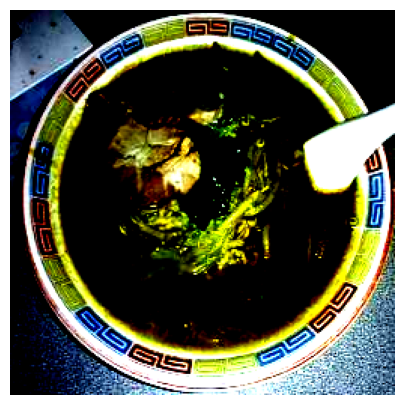

25

ramen

torch.Size([64, 3, 256, 256])
torch.Size([64])

25

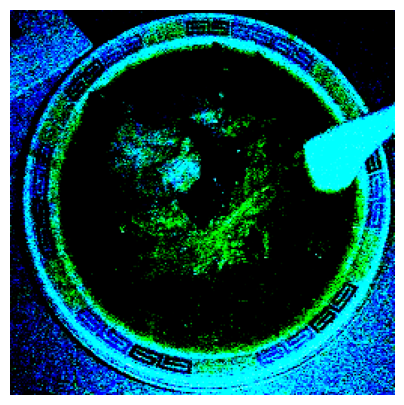

25

ramen

torch.Size([128, 3, 256, 256])
torch.Size([128])

197

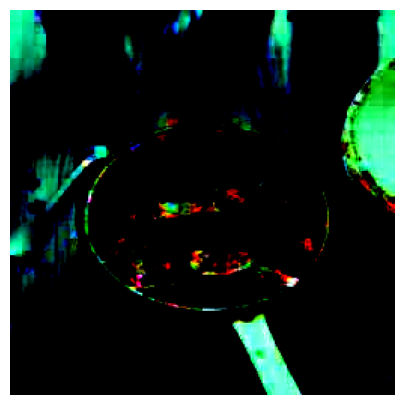

197

clam_food

torch.Size([512, 3, 256, 256])
torch.Size([512])

105

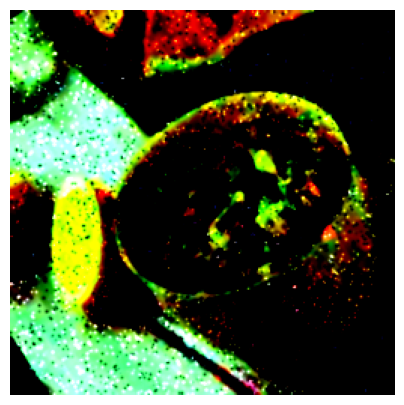

105

guacamole

In [ ]:
check_integrity(test_dl)
check_integrity(test_dl_degraded)
check_integrity(val_dl)
check_integrity(trn_dl)

# Models


In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
!pip install torch_summary
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:


# since there's no need for updating weights,
# we might as well not compute the gradients.
# Using this '@' decorator on top of functions
# will disable gradient computation in the entire function
@torch.no_grad()
def accuracy(x, y, model):

  # ----------------------------------
  # model.eval() is a kind of switch for some specific layers/parts of the model that behave differently 
  # during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. 
  # You need to turn them off during model evaluation, and .eval() will do it for you. 
  # In addition, the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation.
  # from: https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
  model.eval() # <- let's wait till we get to dropout section
  # ----------------------------------



  # ----------------------------------
  # get the prediction matrix for a tensor of `x` images
  prediction = model(x)
  return accuracy_top_k(prediction, y)
  # In the following lines of code, we are explicitly mentioning that we don't
  # need to calculate the gradient by providing @torch.no_grad() and
  # calculating the prediction values by feed-forwarding input through the
  # model
  # ----------------------------------




  # ----------------------------------
  # compute if the location of maximum in each row
  # coincides with ground truth
  # we invoke prediction.max(-1) to identify the argmax index corresponding to each row.
  
  
  # max_values, argmaxes = prediction.max(1) 
  
  
  # max_values_y, argmaxes_y = y.max(-1) 
  # ----------------------------------



  # ----------------------------------
  # Furthermore, we are comparing our argmaxes with the ground truth
  # through argmaxes == y so that we can check whether each row is
  # predicted correctly.


  # is_correct = argmaxes == y
  
  
  # ----------------------------------



  # ----------------------------------
  # return is_correct.cpu().numpy().tolist(), accuracy_top_k(prediction, y) # Finally, we are returning the list of is_correct objects after moving it to a CPU and converting it into a numpy array.
  # ----------------------------------




# Define a function that calculates the loss of the validation data; that
# is, val_loss. Note that we are calculating this separately since loss of
# training data is getting calculated while training the model
@torch.no_grad()
def val_loss(x, y, model):
  # As you can see, we are applying torch.no_grad because we are not
  # training the model and only fetching predictions. Furthermore, we are
  # passing our prediction through the loss function (loss_fn) and
  # returning the loss value (val_loss.item()).
  model.eval()
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()



def accuracy_top_k(output: torch.Tensor, target: torch.Tensor, topk=(1,3)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-5 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.

    ref:
    - https://pytorch.org/docs/stable/generated/torch.topk.html
    - https://discuss.pytorch.org/t/imagenet-example-accuracy-calculation/7840
    - https://gist.github.com/weiaicunzai/2a5ae6eac6712c70bde0630f3e76b77b
    - https://discuss.pytorch.org/t/top-k-error-calculation/48815/2
    - https://stackoverflow.com/questions/59474987/how-to-get-top-k-accuracy-in-semantic-segmentation-using-pytorch

    :param output: output is the prediction of the model e.g. scores, logits, raw y_pred before normalization or getting classes
    :param target: target is the truth
    :param topk: tuple of topk's to compute e.g. (1, 2, 5) computes top 1, top 2 and top 5.
    e.g. in top 2 it means you get a +1 if your models's top 2 predictions are in the right label.
    So if your model predicts cat, dog (0, 1) and the true label was bird (3) you get zero
    but if it were either cat or dog you'd accumulate +1 for that example.
    :return: list of topk accuracy [top1st, top2nd, ...] depending on your topk input
    """
    with torch.no_grad():
        # ---- get the topk most likely labels according to your model
        # get the largest k \in [n_classes] (i.e. the number of most likely probabilities we will use)
        maxk = max(topk)  # max number labels we will consider in the right choices for out model
        batch_size = target.size(0)

        # get top maxk indicies that correspond to the most likely probability scores
        # (note _ means we don't care about the actual top maxk scores just their corresponding indicies/labels)
        _, y_pred = output.topk(k=maxk, dim=1)  # _, [B, n_classes] -> [B, maxk]
        y_pred = y_pred.t()  # [B, maxk] -> [maxk, B] Expects input to be <= 2-D tensor and transposes dimensions 0 and 1.
        # print(y_pred.cpu().numpy())

        # - get the credit for each example if the models predictions is in maxk values (main crux of code)
        # for any example, the model will get credit if it's prediction matches the ground truth
        # for each example we compare if the model's best prediction matches the truth. If yes we get an entry of 1.
        # if the k'th top answer of the model matches the truth we get 1.
        # Note: this for any example in batch we can only ever get 1 match (so we never overestimate accuracy <1)
        target_reshaped = target.view(1, -1).expand_as(y_pred)  # [B] -> [B, 1] -> [maxk, B]
        # print(target_reshaped.cpu().numpy())
        # compare every topk's model prediction with the ground truth & give credit if any matches the ground truth
        correct = (y_pred == target_reshaped)  # [maxk, B] were for each example we know which topk prediction matched truth
        # print(correct.cpu().numpy())
        # original: correct = pred.eq(target.view(1, -1).expand_as(pred))

        # -- get topk accuracy
        list_topk_accs = []  # idx is topk1, topk2, ... etc
        for k in topk:
            # print(k)
            # get tensor of which topk answer was right
            ind_which_topk_matched_truth = correct[:k]  # [maxk, B] -> [k, B]
            # print(ind_which_topk_matched_truth.cpu().numpy())

            # flatten it to help compute if we got it correct for each example in batch
            flattened_indicator_which_topk_matched_truth = ind_which_topk_matched_truth.reshape(-1).float()  # [k, B] -> [kB]
            # print(flattened_indicator_which_topk_matched_truth.cpu().numpy())

            # get if we got it right for any of our top k prediction for each example in batch
            tot_correct_topk = flattened_indicator_which_topk_matched_truth.float().sum(dim=0, keepdim=True)  # [kB] -> [1]
            # print(tot_correct_topk)
            
            # compute topk accuracy - the accuracy of the mode's ability to get it right within it's top k guesses/preds
            topk_acc = tot_correct_topk / batch_size  # topk accuracy for entire batch
            # print(topk_acc)
            
            list_topk_accs.append(topk_acc)
        return list_topk_accs  # list of topk accuracies for entire batch [topk1, topk2, ... etc]

In [ ]:
from torch import optim

def start_training(model, epochs, n_epochs=0):
  log = Report(epochs)
  
  # we are specifying that we're reducing the learning rate
  # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
  
 
  # Invoke the lists that contain the accuracy and loss values at the end of each epoch
  train_losses, train_accuracies_1, train_accuracies_3 = [], [], [] 
  val_losses, val_accuracies_1, val_accuracies_3 = [], [], []


  for epoch in range(epochs): # Define the number of epochs
    print(f" epoch {epoch + 1}/{epochs}")


    #--------------------------------
    # Invoke the lists that will contain the accuracy and loss values
    # corresponding to each batch within an epoch
    train_epoch_losses, train_epoch_accuracies_1, train_epoch_accuracies_3 = [], [], []
    val_epoch_losses, val_epoch_accuracies_1, val_epoch_accuracies_3 = [], [], []
    #--------------------------------



    #--------------------------------
    N = len(trn_dl)
    for ix, batch in enumerate(iter(trn_dl)): # Create batches of training data by iterating through the DataLoader
      x, y = batch
      
      # Train the batch using the train_batch function and store the loss value at
      # the end of training on top of the batch as batch_loss. Furthermore, store
      # the loss values across batches in the epoch_losses list:

      batch_loss = train_batch(x, y, model, optimizer, loss_fn, debug=False)
      train_epoch_losses.append(batch_loss)
      log.record(epoch+(ix+1)/N, trn_loss=batch_loss, end='\r')

    # We store the mean loss value across all batches within an epoch:
    train_epoch_loss = np.array(train_epoch_losses).mean()
    #--------------------------------
    save_model(model, epoch+n_epochs)



    #--------------------------------
    # Next, we calculate the accuracy of the prediction at the end of training on
    # all batches:
    for ix, batch in enumerate(iter(trn_dl)):
      x, y = batch
      top_1, top_3 = accuracy(x, y, model)
      train_epoch_accuracies_1.extend(top_1.cpu().numpy())
      train_epoch_accuracies_3.extend(top_3.cpu().numpy())

    train_epoch_accuracy_1 = np.mean(train_epoch_accuracies_1)
    train_epoch_accuracy_3 = np.mean(train_epoch_accuracies_3)
    #--------------------------------


    #--------------------------------
    N = len(val_dl)
    for ix, batch in enumerate(iter(val_dl)):
      x, y = batch

      validation_loss = val_loss(x, y, model)
      val_epoch_losses.append(validation_loss)
      log.record(epoch+(ix+1)/N, val_loss=validation_loss, end='\r')
    
    val_epoch_losses = np.array(val_epoch_losses).mean()
    #--------------------------------




    #--------------------------------
    for ix, batch in enumerate(iter(val_dl)):
      x, y = batch
      top_1, top_3 = accuracy(x, y, model)
      val_epoch_accuracies_1.extend(top_1.cpu().numpy())
      val_epoch_accuracies_3.extend(top_3.cpu().numpy())

    val_epoch_accuracy_1 = np.mean(val_epoch_accuracies_1)
    val_epoch_accuracy_3 = np.mean(val_epoch_accuracies_3)
    #--------------------------------



    #--------------------------------
    # Store the loss and accuracy values at the end of each epoch in a list

    log.report_avgs(epoch+1)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_losses)

    train_accuracies_1.append(train_epoch_accuracy_1)
    train_accuracies_3.append(train_epoch_accuracy_3)

    val_accuracies_1.append(val_epoch_accuracy_1)
    val_accuracies_3.append(val_epoch_accuracy_3)

    #--------------------------------
    save_model(model, epoch+n_epochs)


    print("Accuracy = {}".format(train_epoch_accuracy_1))
    print("Accuracy Validation= {}".format(val_epoch_accuracy_1))
    print(" \n --------- top 3 accuracy ---------")
    
    print("Accuracy top3 = {}".format(train_epoch_accuracy_3))
    print("Accuracy top3 Validation= {}".format(val_epoch_accuracy_3))


    #--------------------------------
    # if (epoch+1)%2 == 0:
    # save_model(model, epoch)
    #--------------------------------

  log.plot_epochs()
  return train_losses, train_accuracies, val_losses, val_accuracies
    

In [ ]:
def plot(epochs, train_losses, train_accuracies, val_losses, val_accuracies):
  epochs = np.arange(epochs)+1
  import matplotlib.ticker as mtick
  import matplotlib.pyplot as plt
  import matplotlib.ticker as mticker
  %matplotlib inline
  plt.subplot(211)
  plt.plot(epochs, train_losses, 'bo', label='Training loss')
  plt.plot(epochs, val_losses, 'r', label='Validation loss')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid('off')
  plt.show()
  plt.subplot(212)
  plt.plot(epochs, train_accuracies, 'bo', \
  label='Training accuracy')
  plt.plot(epochs, val_accuracies, 'r', \
  label='Validation accuracy')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
  for x in plt.gca().get_yticks()])
  plt.legend()
  plt.grid('off')
  plt.show()

In [ ]:
!pip install torchmetrics

from sklearn.metrics import f1_score
from torchmetrics.classification import MulticlassF1Score


def accuracy_on_test(model, test_data):
  acc_1, acc_3 = [],[]
  for ix, batch in enumerate(iter(test_data)):
    x, y = batch
    top_1, top_3 = accuracy(x, y, model)
    acc_1.extend(top_1.cpu().numpy())
    acc_3.extend(top_3.cpu().numpy()) 

  return np.mean(acc_3), np.mean(acc_1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.1 MB/s eta 0:00:00


## SWIN_V2_T
https://arxiv.org/abs/2103.14030

In [ ]:
def train_batch(x, y, model, opt, loss_fn, debug=False):
  '''
  This code passes the batch of images through the model in the
  forward pass. It also computes the loss on batch and then passes the
  weights through backward propagation and updates them. Finally, it
  flushes the memory of the gradient so that it doesn't influence how the
  gradient is calculated in the next pass.
  '''
  model.train() # <- let's hold on to this until we reach dropout section


  # ----------------------------------
  # call your model like any python function on your batch
  # of inputs
  # see this: https://discuss.pytorch.org/t/why-the-torch-max-of-predictions-and-f-softmax-pred-are-equal-and-what-is-the-logic-behind-this/141019/2
  prediction = model(x)
  _, argmaxes_prediction = torch.max(prediction, dim=1) 
  # ----------------------------------

  if debug:
    print("\n\n\n ---------------------------------- PREDICTION ----------------------------------")
    print(prediction.detach().cpu().numpy()[0])
    print(prediction.detach().cpu().numpy()[1])
    
    print(argmaxes_prediction.detach().cpu().numpy())


    print("--------------------------------- GT ----------------------------------")
    print(y)
    print(y.cpu().numpy())



  # ----------------------------------
  # compute loss
  l2_regularization = 0 # l2 regularization
  for param in model.parameters():
    l2_regularization += torch.norm(param,2)
  
  batch_loss = loss_fn(prediction, y) + 0.001*l2_regularization
  # ----------------------------------


  # ----------------------------------
  # based on the forward pass in `model(x)` compute all the
  # gradients of 'model.parameters()'
  batch_loss.backward()
  # ----------------------------------


  # ----------------------------------
  # apply new-weights = f(old-weights, old-weight-gradients)
  # where "f" is the optimizer
  optimizer.step()
  # ----------------------------------


  # ----------------------------------
  # Flush gradients memory for next batch of calculations
  optimizer.zero_grad()
  if debug:
    print(batch_loss.item())

  return batch_loss.item() # Now that we've done this, we can extract the loss value as a scalar by fetching batch_loss.item() on top of batch_loss
  # ----------------------------------


In [ ]:
def get_model():
  model = models.swin_v2_t(weights='DEFAULT').to(device)

  print(model)

  # Specify that we want to freeze all the parameters in the model
  # downloaded previously
  # for child in model.children():
  #   print(child)
  
  for param in model.parameters():
    param.requires_grad = False

  
  for param in model.features[7].parameters():
    param.requires_grad = True
  
  for param in model.features[6].parameters():
    param.requires_grad = True
  
  
  # Replace the avgpool module to return a feature map of size 1 x 1
  # instead of 7 x 7, in other words, the output is now going to be
  # batch_size x 512 (example) x 1 x 1:

  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

  # The layer above, nn.AdaptiveAvgPool2d, is yet
  # another pooling layer with a twist. We specify the output feature
  # map size instead. The layer automatically computes the kernel size
  # so that the specified feature map size is returned. For example, if the
  # input feature map size dimensions were batch_size x 512 x k
  # x k, then the pooling kernel size is going to be k x k. The major
  # advantage with this layer is that whatever the input size, the output
  # from this layer is always fixed and, hence, the neural network can
  # accept images of any height and width.




  # Define the classifier module of the model, where we first flatten
  # the output of the avgpool module, connect the 512 units to the 256
  # units, and perform an activation prior to connecting to the output
  # layer:

  model.head = nn.Sequential(
                                    nn.Linear(768, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, NUM_CLASSES)
                                    )
  
  
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr= 1e-4)
  return model.to(device), loss_fn, optimizer

def get_saved_model(model):
  convnext_path = PROJ_PATH+"SwinTransformer.pth"
  state_dict = torch.load(convnext_path)
  model.load_state_dict(state_dict['state'])
  return model.to(device), state_dict['epoch']
  # model(torch.tensor(val).float().to(device))
  

In [ ]:
model, loss_fn, optimizer = get_model()
model, n_epochs = get_saved_model(model)


Downloading: "https://download.pytorch.org/models/swin_v2_t-b137f0e2.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_t-b137f0e2.pth
100%|██████████| 109M/109M [00:00<00:00, 196MB/s] 


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.018181818181818184, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (2): PatchMergingV2(
      (reduction): Linear(in_features=384, out_features=192, bias=False)
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (3): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=6, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.03636363636363637, mode=row)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=192, out_features=768, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=768, out_features=192, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlockV2(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=6, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.05454545454545456, mode=row)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
  

In [ ]:
model.__class__.__name__

'SwinTransformer'

In [ ]:
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(1,3,224,224))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                                  Output Shape              Param #
├─Sequential: 1-1                                       [-1, 7, 7, 768]           --
|    └─Sequential: 2-1                                  [-1, 56, 56, 96]          --
|    |    └─Conv2d: 3-1                                 [-1, 96, 56, 56]          (4,704)
|    |    └─Permute: 3-2                                [-1, 56, 56, 96]          --
|    |    └─LayerNorm: 3-3                              [-1, 56, 56, 96]          (192)
|    └─Sequential: 2-2                                  [-1, 56, 56, 96]          --
|    |    └─SwinTransformerBlockV2: 3-4                 [-1, 56, 56, 96]          (114,915)
|    |    └─SwinTransformerBlockV2: 3-5                 [-1, 56, 56, 96]          (114,915)
|    └─PatchMergingV2: 2-3                              [-1, 28, 28, 192]         --
|    |    └─Linear: 3-6 

Layer (type:depth-idx)                                  Output Shape              Param #
├─Sequential: 1-1                                       [-1, 7, 7, 768]           --
|    └─Sequential: 2-1                                  [-1, 56, 56, 96]          --
|    |    └─Conv2d: 3-1                                 [-1, 96, 56, 56]          (4,704)
|    |    └─Permute: 3-2                                [-1, 56, 56, 96]          --
|    |    └─LayerNorm: 3-3                              [-1, 56, 56, 96]          (192)
|    └─Sequential: 2-2                                  [-1, 56, 56, 96]          --
|    |    └─SwinTransformerBlockV2: 3-4                 [-1, 56, 56, 96]          (114,915)
|    |    └─SwinTransformerBlockV2: 3-5                 [-1, 56, 56, 96]          (114,915)
|    └─PatchMergingV2: 2-3                              [-1, 28, 28, 192]         --
|    |    └─Linear: 3-6                                 [-1, 28, 28, 192]         (73,728)
|    |    └─LayerNorm: 3-7      

In [ ]:

epochs = 3


In [ ]:
%%script false --no-raise-error
train_losses, train_accuracies, val_losses, val_accuracies = start_training(model, epochs, n_epochs)

### Analysis

In [ ]:
swin_info = {}

In [ ]:
top3, top1 = accuracy_on_test(model, test_dl_degraded) #(0.5201578, 0.33742073)
swin_info["top3_degraded"] = top3
swin_info["top1_degraded"] = top1


In [ ]:
top3, top1 = accuracy_on_test(model, test_dl) #(0.7615781, 0.5631777)
swin_info["top3_not_degraded"] = top3
swin_info["top1_not_degraded"] = top1


## Convnext tiny

https://arxiv.org/abs/2201.03545

In [ ]:
def train_batch(x, y, model, opt, loss_fn, debug=False):
  '''
  This code passes the batch of images through the model in the
  forward pass. It also computes the loss on batch and then passes the
  weights through backward propagation and updates them. Finally, it
  flushes the memory of the gradient so that it doesn't influence how the
  gradient is calculated in the next pass.
  '''
  model.train() # <- let's hold on to this until we reach dropout section


  # ----------------------------------
  # call your model like any python function on your batch
  # of inputs
  # see this: https://discuss.pytorch.org/t/why-the-torch-max-of-predictions-and-f-softmax-pred-are-equal-and-what-is-the-logic-behind-this/141019/2
  prediction = model(x)
  _, argmaxes_prediction = torch.max(prediction, dim=1) 
  # ----------------------------------

  if debug:
    print("\n\n\n ---------------------------------- PREDICTION ----------------------------------")
    print(prediction.detach().cpu().numpy()[0])
    print(prediction.detach().cpu().numpy()[1])
    
    print(argmaxes_prediction.detach().cpu().numpy())


    print("--------------------------------- GT ----------------------------------")
    print(y)
    print(y.cpu().numpy())



  # ----------------------------------
  # compute loss
  l2_regularization = 0 # l2 regularization
  for param in model.parameters():
    l2_regularization += torch.norm(param,2)
  
  batch_loss = loss_fn(prediction, y) + 0.001*l2_regularization
  # ----------------------------------


  # ----------------------------------
  # based on the forward pass in `model(x)` compute all the
  # gradients of 'model.parameters()'
  batch_loss.backward()
  # ----------------------------------


  # ----------------------------------
  # apply new-weights = f(old-weights, old-weight-gradients)
  # where "f" is the optimizer
  optimizer.step()
  # ----------------------------------


  # ----------------------------------
  # Flush gradients memory for next batch of calculations
  optimizer.zero_grad()
  if debug:
    print(batch_loss.item())

  return batch_loss.item() # Now that we've done this, we can extract the loss value as a scalar by fetching batch_loss.item() on top of batch_loss
  # ----------------------------------


In [ ]:
def get_model():
  # model = models.vgg16(weights='DEFAULT').to(device)
  model = models.convnext_tiny(weights='DEFAULT').to(device)

  print(model)

  # Specify that we want to freeze all the parameters in the model
  # downloaded previously
  # for child in model.children():
  #   print(child)
  
  for param in model.parameters():
    param.requires_grad = False

  for param in model.features[7].parameters():
    param.requires_grad = True
  
  for param in model.features[6].parameters():
    param.requires_grad = True
  
  for param in model.features[5][3:8].parameters():
    param.requires_grad = True
  
  
  # Replace the avgpool module to return a feature map of size 1 x 1
  # instead of 7 x 7, in other words, the output is now going to be
  # batch_size x 512 (example) x 1 x 1:

  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

  # The layer above, nn.AdaptiveAvgPool2d, is yet
  # another pooling layer with a twist. We specify the output feature
  # map size instead. The layer automatically computes the kernel size
  # so that the specified feature map size is returned. For example, if the
  # input feature map size dimensions were batch_size x 512 x k
  # x k, then the pooling kernel size is going to be k x k. The major
  # advantage with this layer is that whatever the input size, the output
  # from this layer is always fixed and, hence, the neural network can
  # accept images of any height and width.




  # Define the classifier module of the model, where we first flatten
  # the output of the avgpool module, connect the 512 units to the 256
  # units, and perform an activation prior to connecting to the output
  # layer:

  model.classifier[2] = nn.Sequential(
                                    nn.Linear(768, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, NUM_CLASSES)
                                    )
  
  
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr= 1e-5)
  return model.to(device), loss_fn, optimizer

def get_saved_model(model):
  convnext_path = PROJ_PATH+"ConvNeXt.pth"
  state_dict = torch.load(convnext_path)
  model.load_state_dict(state_dict['state'])
  return model.to(device), state_dict['epoch']
  # model(torch.tensor(val).float().to(device))
  

In [ ]:
model, loss_fn, optimizer = get_model()
model, n_epochs = get_saved_model(model)
n_epochs
# model.classifier[2] = nn.Sequential(
#                                   nn.Linear(768, 512),
#                                   nn.ReLU(),
#                                   nn.Dropout(0.2),
#                                   nn.Linear(512, NUM_CLASSES)
#     


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 183MB/s]


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0058823529411764705, mode=row)
      )
      (2): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.011764705882352941, mode=row)
      )
    )
    (2): Sequential(
      (0): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.017647058823529415, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.023529411764705882, mode=row)
      )
      (2): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.029411764705882353, mode=row)
      )
    )
    (4): Sequential(
      (0): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (5): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(384, 384, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=384)
          (1): Permute()
          (2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)


9

In [ ]:
model.__class__.__name__

'ConvNeXt'

In [ ]:
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(1,3,224,224))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 768, 7, 7]           --
|    └─Conv2dNormActivation: 2-1              [-1, 96, 56, 56]          --
|    |    └─Conv2d: 3-1                       [-1, 96, 56, 56]          (4,704)
|    |    └─LayerNorm2d: 3-2                  [-1, 96, 56, 56]          (192)
|    └─Sequential: 2-2                        [-1, 96, 56, 56]          --
|    |    └─CNBlock: 3-3                      [-1, 96, 56, 56]          (79,296)
|    |    └─CNBlock: 3-4                      [-1, 96, 56, 56]          (79,296)
|    |    └─CNBlock: 3-5                      [-1, 96, 56, 56]          (79,296)
|    └─Sequential: 2-3                        [-1, 192, 28, 28]         --
|    |    └─LayerNorm2d: 3-6                  [-1, 96, 56, 56]          (192)
|    |    └─Conv2d: 3-7                   

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 768, 7, 7]           --
|    └─Conv2dNormActivation: 2-1              [-1, 96, 56, 56]          --
|    |    └─Conv2d: 3-1                       [-1, 96, 56, 56]          (4,704)
|    |    └─LayerNorm2d: 3-2                  [-1, 96, 56, 56]          (192)
|    └─Sequential: 2-2                        [-1, 96, 56, 56]          --
|    |    └─CNBlock: 3-3                      [-1, 96, 56, 56]          (79,296)
|    |    └─CNBlock: 3-4                      [-1, 96, 56, 56]          (79,296)
|    |    └─CNBlock: 3-5                      [-1, 96, 56, 56]          (79,296)
|    └─Sequential: 2-3                        [-1, 192, 28, 28]         --
|    |    └─LayerNorm2d: 3-6                  [-1, 96, 56, 56]          (192)
|    |    └─Conv2d: 3-7                       [-1, 192, 28, 28]         (73,920)
|    └─Sequential: 2-4                        [-1, 192, 28, 

In [ ]:
epochs = 3


In [ ]:
%%script false --no-raise-error

train_losses, train_accuracies, val_losses, val_accuracies = start_training(model, epochs)

### Analysis

In [ ]:
convnext_info = {}

In [ ]:
top3, top1 = accuracy_on_test(model, test_dl_degraded) # (0.500211, 0.33657682)
convnext_info["top3_degraded"] = top3
convnext_info["top1_degraded"] = top1


In [ ]:
top3, top1 = accuracy_on_test(model, test_dl) # (0.7161224, 0.52107203)
convnext_info["top3_not_degraded"] = top3
convnext_info["top1_not_degraded"] = top1


# Summary

In [75]:
convnext_info =  pd.read_csv(PROJ_PATH+"convnext_info.csv") #pd.DataFrame(convnext_info, index=[0])
swin_info = pd.read_csv(PROJ_PATH+"swin_info.csv") #pd.DataFrame(swin_info, index=[0])

In [76]:
swin_info

,top3_degraded,top1_degraded,top3_not_degraded,top1_not_degraded
0,0.519915,0.337664,0.761942,0.563542


In [77]:
convnext_info

,top3_degraded,top1_degraded,top3_not_degraded,top1_not_degraded
0,0.499968,0.336334,0.716608,0.521558


In [78]:
# swin_info.to_csv(PROJ_PATH+"swin_info.csv", index=False)
# convnext_info.to_csv(PROJ_PATH+"convnext_info.csv", index=False)

In [79]:
summary = pd.concat([swin_info, convnext_info]).reset_index(drop=True)
summary["model"] = "swin"
summary.loc[1, ["model"]] = "convnext"
summary

,top3_degraded,top1_degraded,top3_not_degraded,top1_not_degraded,model
0,0.519915,0.337664,0.761942,0.563542,swin
1,0.499968,0.336334,0.716608,0.521558,convnext


In [80]:
swin_info.to_dict("index")[0]

{'top3_degraded': 0.5199148,
 'top1_degraded': 0.33766368,
 'top3_not_degraded': 0.7619425,
 'top1_not_degraded': 0.5635421}

In [81]:
def plot_accuracy_metrics(dataframe, name):
  x = np.arange(len(dataframe.columns.values))  # the label locations
  # creating the dataset
  data = dataframe.to_dict("index")[0]
  courses = list(data.keys())
  values = list(data.values())
    
  fig = plt.figure(figsize = (10, 5))
  
  # creating the bar plot
  plt.bar(courses, values,
          width = 0.4)
  
  plt.xlabel("Metrics")
  plt.ylabel("Accuracy")
  plt.title(f"Accuracy {name}")
  plt.show()

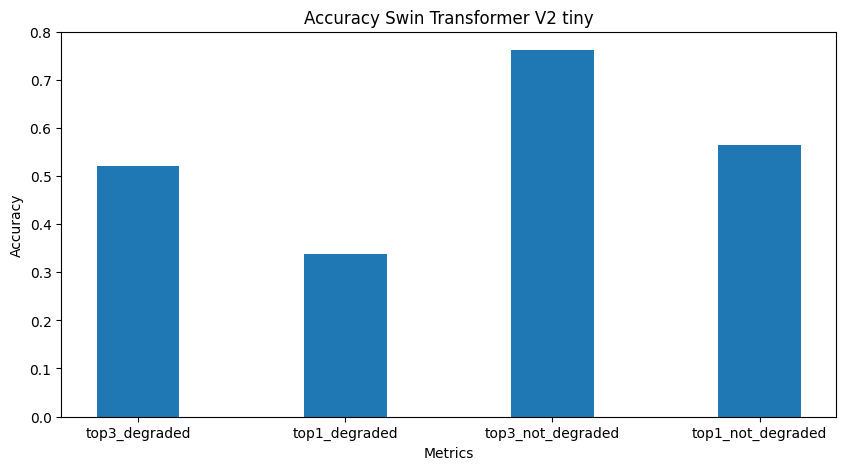

In [82]:
plot_accuracy_metrics(swin_info, "Swin Transformer V2 tiny")

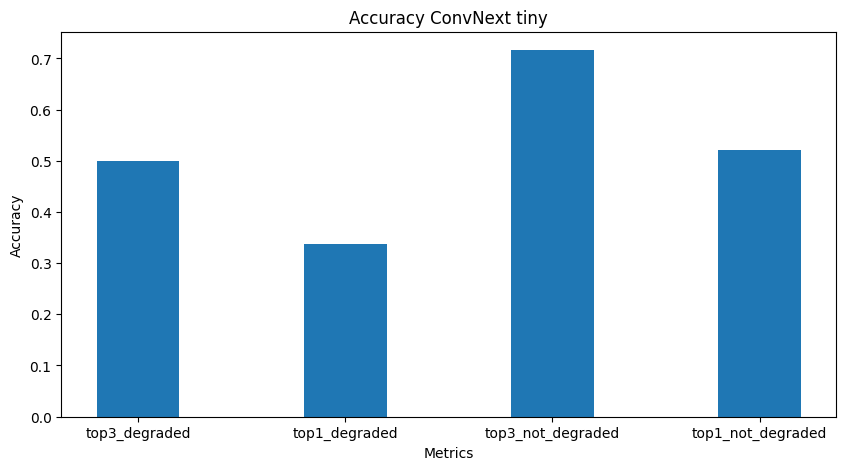

In [83]:
plot_accuracy_metrics(convnext_info, "ConvNext tiny")

In [84]:
convnext_info.iloc[0].to_list()

[0.49996802, 0.33633387, 0.7166082, 0.5215579]

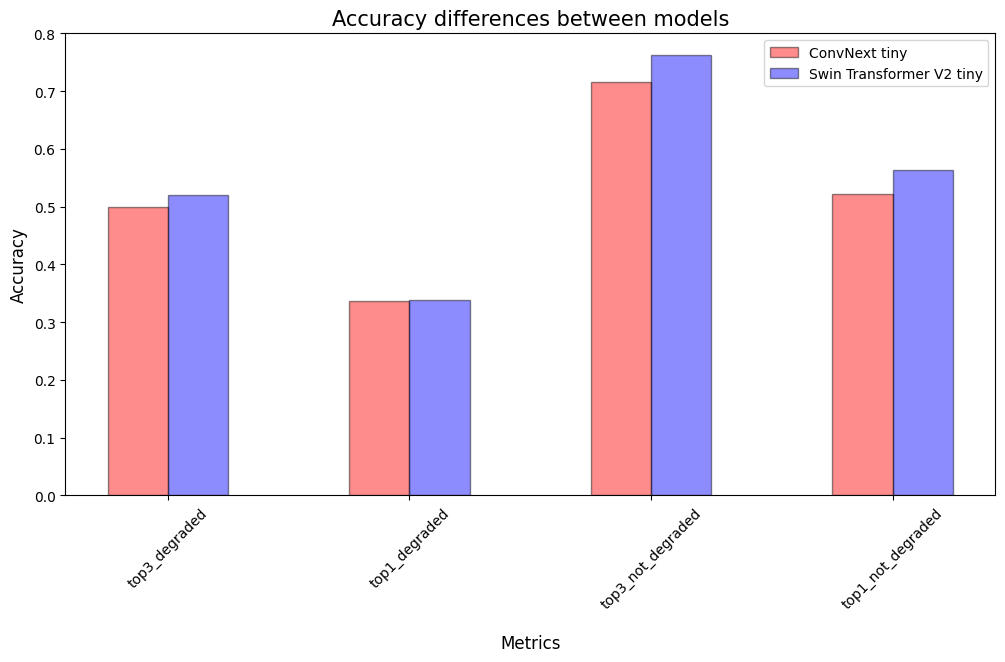

In [90]:
convnext_values = convnext_info.iloc[0].to_list()
swin_values = swin_info.iloc[0].to_list()

n=4
r = np.arange(n)
width = 0.25
  
f, ax = plt.subplots(figsize=(12,6)) # set the size that you'd like (width, height)
plt.bar(r, convnext_values,  alpha=0.45, color='red',
        width = width, edgecolor = 'black',
        label='ConvNext tiny')
plt.bar(r + width, swin_values, alpha=0.45, color='blue',
        width = width, edgecolor = 'black',
        label='Swin Transformer V2 tiny')
  
plt.xlabel("Metrics",  size = 12)
plt.ylabel("Accuracy",  size = 12)
plt.title("Accuracy differences between models",  size = 15)
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2,convnext_info.columns.values, size = 10, rotation = 45)
ax.legend(fontsize = 10)
ax.xaxis.set_label_coords(.5, -.3)

plt.show()